# OpenMathReasoning データセットのトークン長分析

このノートブックでは、train.parquetファイルのprompt+responseを連結し、Qwen3でトークン化して最長トークン数を求めます。

In [1]:
# 必要なライブラリのインストール
!pip install transformers torch pandas datasets pyarrow matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import os
from tqdm import tqdm
import json

## 1. データの読み込み

In [3]:
# データファイルのパス
data_path = os.path.expanduser("/kaggle/input/open-math-reasoning-10fold/train.parquet")

# parquetファイルの読み込み
print(f"データファイルを読み込み中: {data_path}")
df = pd.read_parquet(data_path)
print(f"データ件数: {len(df)}")
print(f"カラム: {df.columns.tolist()}")

データファイルを読み込み中: /kaggle/input/open-math-reasoning-10fold/train.parquet
データ件数: 78798
カラム: ['expected_answer', 'problem_type', 'problem_source', 'generation_model', 'pass_rate_72b_tir', 'problem', 'generated_solution', 'inference_mode', 'used_in_kaggle', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info']


In [4]:
# データの構造を確認
print("最初のサンプルの構造:")
sample = df.iloc[0]
print(f"prompt型: {type(sample['prompt'])}")
print(f"extra_info型: {type(sample['extra_info'])}")

# promptの内容確認
print("\npromptの構造:")
print(sample['prompt'])

# extra_infoの内容確認
print("\nextra_infoの構造:")
if isinstance(sample['extra_info'], str):
    extra_info = json.loads(sample['extra_info'])
else:
    extra_info = sample['extra_info']
print(extra_info.keys())

最初のサンプルの構造:
prompt型: <class 'numpy.ndarray'>
extra_info型: <class 'dict'>

promptの構造:
[{'content': 'Let $G$ be an abelian group and let $H$ and $K$ be subgroups of $G$ with orders $15$ and $20$ respectively. If there exists a subgroup $L$ of $G$ with order $mn$, calculate the value of $m+n$.', 'role': 'user'}]

extra_infoの構造:
dict_keys(['answer', 'expected_answer', 'index', 'inference_mode', 'original_format', 'problem_source', 'problem_type', 'question', 'split'])


## 2. Prompt + Response の抽出と連結

In [5]:
def extract_prompt_response(row):
    """各行からpromptとresponseを抽出して連結"""
    # promptからユーザーメッセージを抽出
    prompt_data = row['prompt']
    if isinstance(prompt_data, str):
        prompt_data = json.loads(prompt_data)
    
    user_content = ""
    for msg in prompt_data:
        if msg.get('role') == 'user':
            user_content = msg.get('content', '')
            break
    
    # extra_infoからresponseを抽出
    extra_info = row['extra_info']
    if isinstance(extra_info, str):
        extra_info = json.loads(extra_info)
    
    response = extra_info.get('answer', '')
    
    # チャット形式で連結
    combined_text = f"User: {user_content}\n\nAssistant: {response}"
    
    return combined_text, user_content, response

In [6]:
# 全データに対してprompt+response抽出を実行
print("prompt + response を抽出中...")
results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="データ処理中"):
    combined_text, prompt, response = extract_prompt_response(row)
    results.append({
        'index': idx,
        'combined_text': combined_text,
        'prompt': prompt,
        'response': response,
        'prompt_length': len(prompt),
        'response_length': len(response),
        'combined_length': len(combined_text)
    })

# 結果をDataFrameに変換
text_df = pd.DataFrame(results)
print(f"処理完了: {len(text_df)} サンプル")

prompt + response を抽出中...


データ処理中: 100%|██████████| 78798/78798 [00:07<00:00, 9926.20it/s]


処理完了: 78798 サンプル


In [7]:
# 文字数統計を表示
print("=== 文字数統計 ===")
print(f"Prompt文字数 - 平均: {text_df['prompt_length'].mean():.1f}, 最大: {text_df['prompt_length'].max()}, 最小: {text_df['prompt_length'].min()}")
print(f"Response文字数 - 平均: {text_df['response_length'].mean():.1f}, 最大: {text_df['response_length'].max()}, 最小: {text_df['response_length'].min()}")
print(f"Combined文字数 - 平均: {text_df['combined_length'].mean():.1f}, 最大: {text_df['combined_length'].max()}, 最小: {text_df['combined_length'].min()}")

# 最長文字数のサンプルを表示
max_idx = text_df['combined_length'].idxmax()
print(f"\n最長文字数サンプル (インデックス: {max_idx}, 文字数: {text_df.loc[max_idx, 'combined_length']})")
print("=" * 50)
print(text_df.loc[max_idx, 'combined_text'][:1000] + "..." if len(text_df.loc[max_idx, 'combined_text']) > 1000 else text_df.loc[max_idx, 'combined_text'])

=== 文字数統計 ===
Prompt文字数 - 平均: 185.7, 最大: 2116, 最小: 15
Response文字数 - 平均: 17433.1, 最大: 73068, 最小: 932
Combined文字数 - 平均: 17637.8, 最大: 73499, 最小: 972

最長文字数サンプル (インデックス: 12014, 文字数: 73499)
User: Joaquim, José, and João are points in the Euclidean plane, each moving with constant velocity \( v \) towards positions that would form a triangle similar to a given triangle \( ABC \) in the order \( A \), \( B \), and \( C \). At each instant \( t \), Joaquim moves to a point in the same half-plane determined by the line connecting José and João, and similarly for the others. Given that they initially do not represent three collinear points, find the minimum time \( t \) in terms of \( v \) and the side lengths of \( ABC \) such that they can form a triangle similar to \( ABC \).

Assistant: <think>
Okay, so I have this problem where Joaquim, José, and João are moving with constant velocity \( v \) towards positions that form a triangle similar to triangle \( ABC \). The question is asking for th

## 3. Qwen3 トークナイザーの設定

In [8]:
# Qwen3トークナイザーをロード
# 利用可能なQwen3系モデルを試す
model_names = [
    "Qwen/Qwen3-0.6B",
    #"Qwen/Qwen2.5-1.5B", 
    #"Qwen/Qwen2.5-3B",
    #"Qwen/Qwen2.5-7B"
]

tokenizer = None
used_model = None

for model_name in model_names:
    try:
        print(f"トークナイザーを試行中: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        used_model = model_name
        print(f"成功: {model_name} のトークナイザーを使用")
        break
    except Exception as e:
        print(f"失敗: {model_name} - {e}")
        continue

if tokenizer is None:
    raise RuntimeError("利用可能なQwen3トークナイザーが見つかりませんでした")

print(f"\n使用するトークナイザー: {used_model}")
print(f"語彙サイズ: {tokenizer.vocab_size}")

トークナイザーを試行中: Qwen/Qwen3-0.6B


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

成功: Qwen/Qwen3-0.6B のトークナイザーを使用

使用するトークナイザー: Qwen/Qwen3-0.6B
語彙サイズ: 151643


## 4. トークン化とトークン長分析

In [9]:
def tokenize_text(text):
    """テキストをトークン化してトークン数を返す"""
    try:
        tokens = tokenizer.encode(text, add_special_tokens=True)
        return len(tokens)
    except Exception as e:
        print(f"トークン化エラー: {e}")
        return 0

In [10]:
# 全サンプルのトークン数を計算
print("トークン化を実行中...")

# バッチ処理でメモリ効率を向上
batch_size = 100
token_counts = []

for i in tqdm(range(0, len(text_df), batch_size), desc="トークン化中"):
    batch = text_df.iloc[i:i+batch_size]
    batch_token_counts = []
    
    for _, row in batch.iterrows():
        token_count = tokenize_text(row['combined_text'])
        batch_token_counts.append(token_count)
    
    token_counts.extend(batch_token_counts)

# 結果をDataFrameに追加
text_df['token_count'] = token_counts
print(f"トークン化完了: {len(text_df)} サンプル")

トークン化を実行中...


トークン化中: 100%|██████████| 788/788 [27:22<00:00,  2.08s/it]

トークン化完了: 78798 サンプル


In [11]:
# トークン数統計を計算・表示
print("=== トークン数統計 ===")
print(f"平均トークン数: {text_df['token_count'].mean():.1f}")
print(f"最大トークン数: {text_df['token_count'].max()}")
print(f"最小トークン数: {text_df['token_count'].min()}")
print(f"中央値: {text_df['token_count'].median():.1f}")
print(f"標準偏差: {text_df['token_count'].std():.1f}")

# パーセンタイル情報
percentiles = [50, 75, 90, 95, 99]
print("\n=== パーセンタイル分布 ===")
for p in percentiles:
    value = np.percentile(text_df['token_count'], p)
    print(f"{p}%tile: {value:.0f} tokens")

=== トークン数統計 ===
平均トークン数: 6190.1
最大トークン数: 25187
最小トークン数: 305
中央値: 5049.0
標準偏差: 4198.1

=== パーセンタイル分布 ===
50%tile: 5049 tokens
75%tile: 8591 tokens
90%tile: 12781 tokens
95%tile: 14900 tokens
99%tile: 17284 tokens


In [12]:
# 最長トークンのサンプルを表示
max_token_idx = text_df['token_count'].idxmax()
max_token_row = text_df.loc[max_token_idx]

print(f"\n=== 最長トークンサンプル ===")
print(f"インデックス: {max_token_idx}")
print(f"トークン数: {max_token_row['token_count']}")
print(f"文字数: {max_token_row['combined_length']}")
print(f"文字数/トークン数比: {max_token_row['combined_length']/max_token_row['token_count']:.2f}")
print("\n=== サンプル内容 ===")
print("=" * 80)
sample_text = max_token_row['combined_text']
if len(sample_text) > 2000:
    print(sample_text[:1000])
    print("\n... [中略] ...\n")
    print(sample_text[-1000:])
else:
    print(sample_text)
print("=" * 80)


=== 最長トークンサンプル ===
インデックス: 60301
トークン数: 25187
文字数: 42849
文字数/トークン数比: 1.70

=== サンプル内容 ===
User: Given the sequences \( p_n \) and \( q_n \) defined by:
\[ p_{-1} = 0, \quad q_{-1} = 1, \quad p_0 = q_0 = 1 \]
\[ p_n = 2p_{n-1} + (2n-1)^2 p_{n-2} \]
\[ q_n = 2q_{n-1} + (2n-1)^2 q_{n-2} \]
Calculate the value of \( \frac{p_{10}}{q_{10}} \).

Assistant: <think>
Okay, so I need to find the value of p₁₀ divided by q₁₀. Both pₙ and qₙ are defined by the same recursive formula, but with different initial conditions. Let me write down the problem again to make sure I have it right.

The sequences are:
p₋₁ = 0, p₀ = 1
q₋₁ = 1, q₀ = 1

And for n ≥ 1,
pₙ = 2pₙ₋₁ + (2n - 1)² pₙ₋₂
qₙ = 2qₙ₋₁ + (2n - 1)² qₙ₋₂

We need to calculate p₁₀ / q₁₀.

Hmm, interesting. Since both pₙ and qₙ follow the same recurrence relation but start with different initial terms, maybe the ratio pₙ/qₙ converges to something or has a pattern. But since we need the 10th term, maybe we just have to compute each term step by st

## 5. 結果の可視化

/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4050781716.py:42: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4

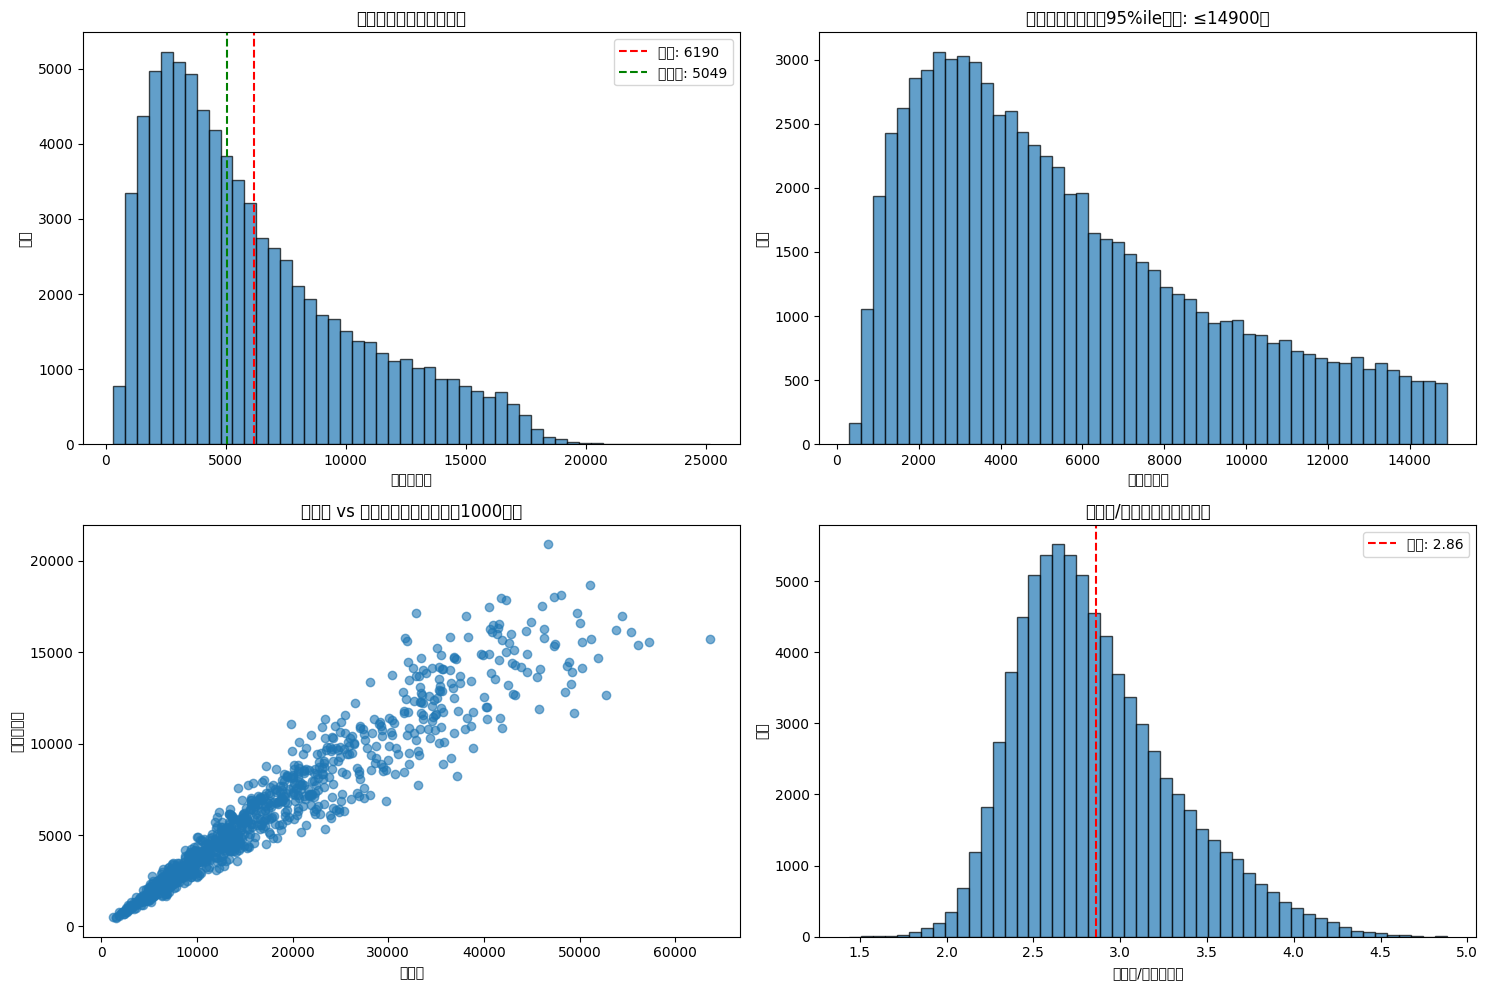

In [13]:
# トークン数分布のヒストグラム
plt.figure(figsize=(15, 10))

# 全体の分布
plt.subplot(2, 2, 1)
plt.hist(text_df['token_count'], bins=50, alpha=0.7, edgecolor='black')
plt.title('トークン数分布（全体）')
plt.xlabel('トークン数')
plt.ylabel('頻度')
plt.axvline(text_df['token_count'].mean(), color='red', linestyle='--', label=f'平均: {text_df["token_count"].mean():.0f}')
plt.axvline(text_df['token_count'].median(), color='green', linestyle='--', label=f'中央値: {text_df["token_count"].median():.0f}')
plt.legend()

# 95%ile以下に絞った分布
plt.subplot(2, 2, 2)
p95 = np.percentile(text_df['token_count'], 95)
filtered_tokens = text_df[text_df['token_count'] <= p95]['token_count']
plt.hist(filtered_tokens, bins=50, alpha=0.7, edgecolor='black')
plt.title(f'トークン数分布（95%ile以下: ≤{p95:.0f}）')
plt.xlabel('トークン数')
plt.ylabel('頻度')

# 文字数 vs トークン数の散布図
plt.subplot(2, 2, 3)
sample_idx = np.random.choice(len(text_df), min(1000, len(text_df)), replace=False)
sample_data = text_df.iloc[sample_idx]
plt.scatter(sample_data['combined_length'], sample_data['token_count'], alpha=0.6)
plt.title('文字数 vs トークン数（サンプル1000件）')
plt.xlabel('文字数')
plt.ylabel('トークン数')

# 文字数/トークン数比の分布
plt.subplot(2, 2, 4)
char_token_ratio = text_df['combined_length'] / text_df['token_count']
plt.hist(char_token_ratio, bins=50, alpha=0.7, edgecolor='black')
plt.title('文字数/トークン数比の分布')
plt.xlabel('文字数/トークン数')
plt.ylabel('頻度')
plt.axvline(char_token_ratio.mean(), color='red', linestyle='--', label=f'平均: {char_token_ratio.mean():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# 上位トークン数サンプルの一覧
print("=== 上位20サンプル（トークン数順） ===")
top_samples = text_df.nlargest(20, 'token_count')[['index', 'token_count', 'combined_length', 'prompt_length', 'response_length']]
top_samples['char_token_ratio'] = top_samples['combined_length'] / top_samples['token_count']
print(top_samples.to_string(index=False))

=== 上位20サンプル（トークン数順） ===
 index  token_count  combined_length  prompt_length  response_length  char_token_ratio
 60301        25187            42849            243            42587          1.701235
 68880        24618            37674            117            37538          1.530344
 58672        24305            40973            234            40720          1.685785
 73398        23333            46713            325            46369          2.002014
  4135        22983            36889            131            36739          1.605056
 42780        22502            43408            326            43063          1.929073
 37073        22027            42661             76            42566          1.936759
 50857        21807            36089            219            35851          1.654927
 77968        21787            42431            291            42121          1.947538
 40587        21747            31300             86            31195          1.439279
   217        2163

In [15]:
# トークン長区間別の分布
bins = [0, 1000, 2000, 4000, 8000, 16000, float('inf')]
labels = ['~1K', '1K-2K', '2K-4K', '4K-8K', '8K-16K', '16K+']
text_df['token_range'] = pd.cut(text_df['token_count'], bins=bins, labels=labels, right=False)

print("=== トークン長区間別分布 ===")
range_counts = text_df['token_range'].value_counts().sort_index()
range_percentage = (range_counts / len(text_df) * 100).round(2)

for range_name, count in range_counts.items():
    percentage = range_percentage[range_name]
    print(f"{range_name:>8}: {count:>6}件 ({percentage:>5.1f}%)")

print(f"\n総件数: {len(text_df)}")
print(f"最大トークン数: {text_df['token_count'].max()}")

=== トークン長区間別分布 ===
     ~1K:   1903件 (  2.4%)
   1K-2K:   8583件 ( 10.9%)
   2K-4K:  20091件 ( 25.5%)
   4K-8K:  26091件 ( 33.1%)
  8K-16K:  19777件 ( 25.1%)
    16K+:   2353件 (  3.0%)

総件数: 78798
最大トークン数: 25187


## 6. 結果のまとめ

In [ ]:
# 結果サマリーを作成
summary = {
    'dataset_info': {
        'total_samples': len(text_df),
        'data_source': 'OpenMathReasoning train.parquet',
        'tokenizer_model': used_model
    },
    'token_statistics': {
        'max_tokens': int(text_df['token_count'].max()),
        'min_tokens': int(text_df['token_count'].min()),
        'mean_tokens': float(text_df['token_count'].mean()),
        'median_tokens': float(text_df['token_count'].median()),
        'std_tokens': float(text_df['token_count'].std())
    },
    'percentiles': {
        f'{p}th': float(np.percentile(text_df['token_count'], p))
        for p in [50, 75, 90, 95, 99]
    },
    'character_statistics': {
        'max_chars': int(text_df['combined_length'].max()),
        'mean_chars': float(text_df['combined_length'].mean()),
        'char_token_ratio': float((text_df['combined_length'] / text_df['token_count']).mean())
    }
}

print("=== 分析結果サマリー ===")
print(json.dumps(summary, indent=2, ensure_ascii=False))

# 結果をファイルに保存
output_path = "token_length_analysis_summary.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print(f"\n結果を保存しました: {output_path}")